In [36]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
print(os.listdir('data'))

import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm

train_df = pd.read_csv(os.path.join('data', 'train.csv'))
sample_df = pd.read_csv(os.path.join('data', 'sample_submission.csv'))

['test_images', 'train.csv', 'train_images', 'sample_submission.csv']


ModuleNotFoundError: No module named 'cv2'

In [17]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [18]:
sample_df.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [19]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [20]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


defaultdict(int, {1: 897, 3: 5150, 4: 801, 2: 247})

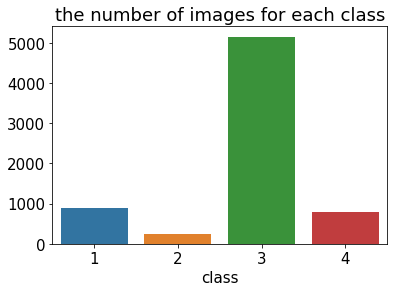

In [21]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

defaultdict(int, {1: 6239, 0: 5902, 2: 425, 3: 2})

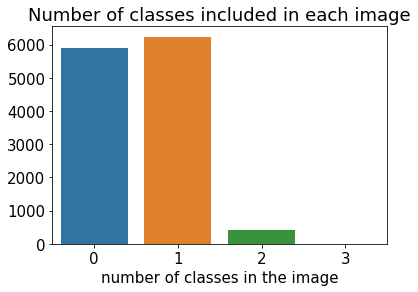

In [22]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

In [24]:
train_size_dict = defaultdict(int)
train_path = Path("data/train_images/")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [25]:
train_size_dict

defaultdict(int, {(1600, 256): 12568})

In [27]:
test_size_dict = defaultdict(int)
test_path = Path("data/test_images/")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

In [28]:
test_size_dict

defaultdict(int, {(1600, 256): 1801})

In [32]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]
def name_and_mask(start_idx):
    col = start_idx
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = train_df.iloc[col:col+4, 1]
    mask = np.zeros((256, 1600, 4), dtype=np.uint8)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            mask_label = np.zeros(1600*256, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(256, 1600, order='F')
    return img_names[0], mask

def show_mask_image(col):
    name, mask = name_and_mask(col)
    img = cv2.imread(str(train_path / name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

    

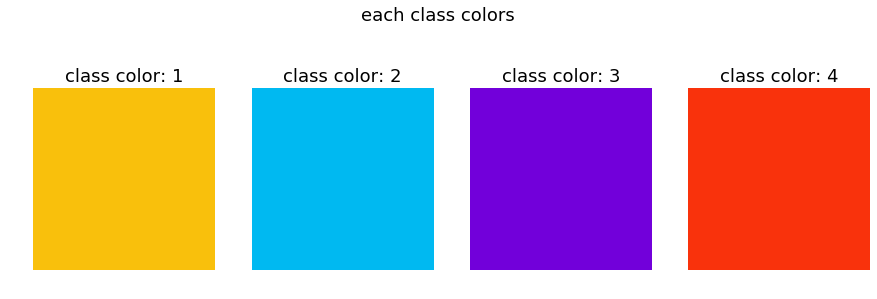

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [34]:
idx_no_defect = []
idx_class_1 = []
idx_class_2 = []
idx_class_3 = []
idx_class_4 = []
idx_class_multi = []
idx_class_triple = []

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError
        
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        idx_no_defect.append(col)
    elif (labels.isna() == [False, True, True, True]).all():
        idx_class_1.append(col)
    elif (labels.isna() == [True, False, True, True]).all():
        idx_class_2.append(col)
    elif (labels.isna() == [True, True, False, True]).all():
        idx_class_3.append(col)
    elif (labels.isna() == [True, True, True, False]).all():
        idx_class_4.append(col)
    elif labels.isna().sum() == 1:
        idx_class_triple.append(col)
    else:
        idx_class_multi.append(col)

In [35]:
for idx in idx_no_defect[:5]:
    show_mask_image(idx)

NameError: name 'cv2' is not defined